In [1]:
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import sys
'geopandas' in sys.modules
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import io
import pandas as pd
import networkx as nx
import osmnx as ox
from pyrosm import OSM, get_data
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Image
from pprint import pprint
import math
from networkx.algorithms import community
from operator import itemgetter

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Useful link
#https://notebook.community/gboeing/urban-data-science/21-Urban-Street-Networks/02-osmnx-network-analysis

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


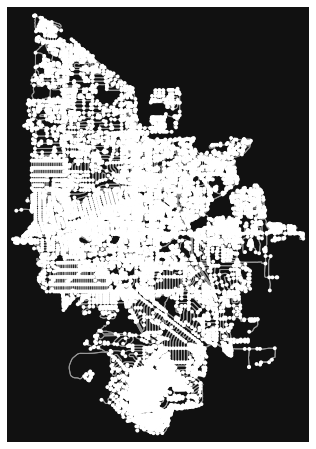

CPU times: total: 16 s
Wall time: 16.5 s


In [3]:
%%time
G = ox.graph_from_place('Boulder, Colorado, USA', network_type='bike',simplify=True) # for County, 'Boulder County'
fig, ax = ox.plot_graph(G)

In [4]:
 # project graph then calculate its nodes’ convex hull area
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

61445539.091817945

In [5]:
%%time
# calculate and print basic network stats
stats = ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True,
circuity_dist='euclidean')
pprint(stats)

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\stats.py:370: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)
C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\stats.py:380: UserWarning: The `clean_intersects` and `tolerance` arguments have been deprecated and will be removed in a future release. Use the `clean_int_tol` argument instead.
  warnings.warn(msg)


{'circuity_avg': 1.100054464038081,
 'clean_intersection_count': 4616,
 'clean_intersection_density_km': 75.12343561836639,
 'edge_density_km': 32740.86231050569,
 'edge_length_avg': 54.884188650934554,
 'edge_length_total': 2011779.935000006,
 'intersection_count': 11190,
 'intersection_density_km': 182.11248799166376,
 'k_avg': 4.946693657219973,
 'm': 36655,
 'n': 14820,
 'node_density_km': 241.1891932114796,
 'self_loop_proportion': 0.009577955337021103,
 'street_density_km': 17558.860430661673,
 'street_length_avg': 55.26089146691236,
 'street_length_total': 1078913.644999997,
 'street_segment_count': 19524,
 'streets_per_node_avg': 2.645748987854251,
 'streets_per_node_counts': {0: 0,
                             1: 3630,
                             2: 85,
                             3: 9090,
                             4: 1944,
                             5: 63,
                             6: 7,
                             7: 1},
 'streets_per_node_proportions': {0: 0.0,
 

 stats : dict
        dictionary containing the following attributes
          - `circuity_avg` - see `circuity_avg` function documentation
          - `clean_intersection_count` - see `clean_intersection_count` function documentation
          - `clean_intersection_density_km` - `clean_intersection_count` per sq km
          - `edge_density_km` - `edge_length_total` per sq km
          - `edge_length_avg` - `edge_length_total / m`
          - `edge_length_total` - see `edge_length_total` function documentation
          - `intersection_count` - see `intersection_count` function documentation
          - `intersection_density_km` - `intersection_count` per sq km
          - `k_avg` - graph's average node degree (in-degree and out-degree)
          - `m` - count of edges in graph
          - `n` - count of nodes in graph
          - `node_density_km` - `n` per sq km
          - `self_loop_proportion` - see `self_loop_proportion` function documentation
          - `street_density_km` - `street_length_total` per sq km
          - `street_length_avg` - `street_length_total / street_segment_count`
          - `street_length_total` - see `street_length_total` function documentation
          - `street_segment_count` - see `street_segment_count` function documentation
          - `streets_per_node_avg` - see `streets_per_node_avg` function documentation
          - `streets_per_node_counts` - see `streets_per_node_counts` function documentation
          - `streets_per_node_proportions` - see `streets_per_node_proportions` function documentation

In [6]:
# calculate and print extended network stats
#more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
#for key in sorted(more_stats.keys()):
#    print(key)

In [7]:
# save the network model to disk as a shapefile and graphml
#https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=clean_intersection_density#module-osmnx.elevation
ox.save_graph_shapefile(G, 'Boulder_network_shapefile')
#ox.save_graphml(G, 'portland_network.graphml')

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [8]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network
P=1
alpha=(stats['street_segment_count']-stats['n']+P)/(2*stats['n']-5)
beta=stats['street_segment_count']/stats['n']
gamma=stats['street_segment_count']/(3*(stats['n']-2))
eta=stats['edge_length_total']/stats['street_segment_count']
gtp=(stats['street_segment_count']-stats['n']+P)/((math.sqrt(stats['n'])-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)
print('clean_intersection_density_km:',stats['clean_intersection_density_km'])
print('Average Circuity:',stats['circuity_avg'])

alpha: 0.15876497384848995
beta: 1.3174089068825912
gamma: 0.4391955729518154
eta: 103.04138163286243
GTP: 0.32275711754050845
clean_intersection_density_km: 75.12343561836639
Average Circuity: 1.100054464038081


# Degree Centrality

In [9]:
# degree Centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, "degree_centrality")

In [10]:
# get the mean closeness centrality
from numpy import array
print('min_dc:', array([degree_centrality[k] for k in degree_centrality]).min())
print('mean_dc:',array([degree_centrality[k] for k in degree_centrality]).mean())
print('max_dc:',array([degree_centrality[k] for k in degree_centrality]).max())
print('std_dc:',array([degree_centrality[k] for k in degree_centrality]).std())

min_dc: 6.74809366354005e-05
mean_dc: 0.0003338075212375986
max_dc: 0.000944733112895607
std_dc: 0.0001315724584905819


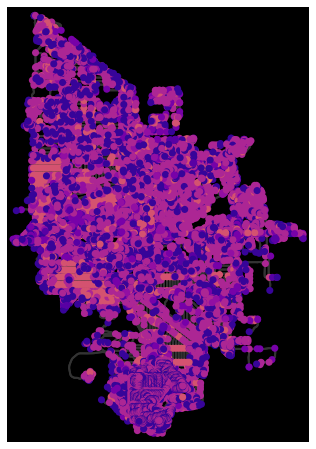

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [11]:
# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "degree_centrality", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, "Degree_Centrality_Boulder_shapefile")

# Closeness Centrality of link

In [12]:
# calculate node closeness centrality of the line graph
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

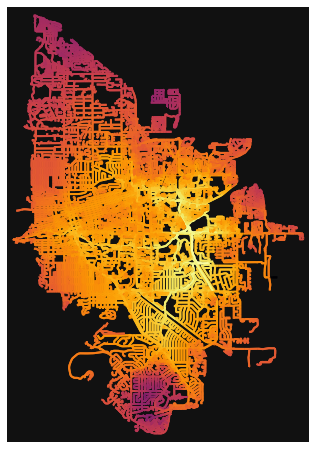

In [13]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

In [14]:
# get the mean closeness centrality
from numpy import array
print('min_ec:', array([edge_centrality[k] for k in edge_centrality]).min())
print('mean_ec:',array([edge_centrality[k] for k in edge_centrality]).mean())
print('max_ec:',array([edge_centrality[k] for k in edge_centrality]).max())
print('std_ec:',array([edge_centrality[k] for k in edge_centrality]).std())

min_ec: 0.0
mean_ec: 0.016449444579884277
max_ec: 0.024158435356964637
std_ec: 0.0032887643779769362


In [15]:
# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, "Closeness_Centrality_Boulder_shapefile")

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:109: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [16]:
# # make a list of graph edge centrality values
# ev = [edge_centrality[edge (0,)] for edge in G.edges()]
# # create a color scale converted to list of colors for graph edges
# norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
# cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
# ec = [cmap.to_rgba(cl) for cl in ev]
# # color the edges in the original graph by closeness centrality in line graph
# fig, ax = ox.plot_graph(G, bgcolor='black', axis_off=True, node_size=0,
# edge_color=ec, edge_linewidth=2, edge_alpha=1)

# Closeness Centrality of  node

In [17]:
# calculate node closeness centrality of the line graph
node_centrality = nx.closeness_centrality((G))
nx.set_node_attributes(G, node_centrality, "node_centrality")

In [18]:
print('min_ncc:', array([node_centrality[k] for k in node_centrality]).min())
print('mean_ncc:',array([node_centrality[k] for k in node_centrality]).mean())
print('max_ncc:',array([node_centrality[k] for k in node_centrality]).max())
print('std_ncc:',array([node_centrality[k] for k in node_centrality]).std())

min_ncc: 0.0
mean_ncc: 0.016120257197379858
max_ncc: 0.023936314095830226
std_ncc: 0.0032485929930038686


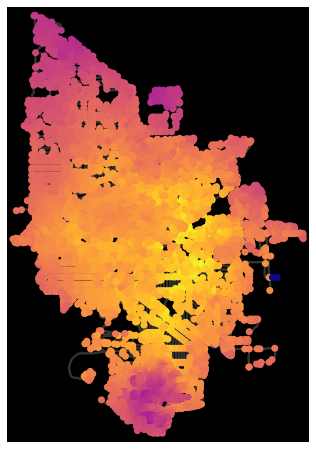

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:109: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [19]:
# plot the graph, coloring nodes by node closeness centrality
ncc = ox.plot.get_node_colors_by_attr(G, "node_centrality", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=ncc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, "Node_closeness_Centrality_Boulder_shapefile")

# Betweenness Centrality

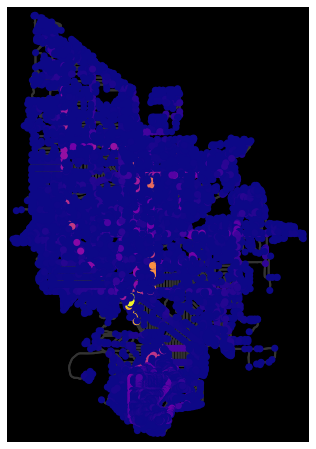

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:109: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [20]:
# Betweenness Centrality
#https://networkx.org/documentation/stable/auto_examples/geospatial/plot_osmnx.html
#https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb
# impute edge (cycling) speeds and calculate edge traversal times
ox.config(use_cache=True, log_console=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, "Betweenness_Centrality_Boulder_shapefile")

In [21]:
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(176438385, 0.23261107122478827)

In [22]:
print('min_bc:', array([bc[k] for k in bc]).min())
print('mean_bc:',array([bc[k] for k in bc]).mean())
print('max_bc:',array([bc[k] for k in bc]).max())
print('std_bc:',array([bc[k] for k in bc]).std())

min_bc: 0.0
mean_bc: 0.006319538513959572
max_bc: 0.23261107122478827
std_bc: 0.019777359726899743


# In the city of Portland, OR, the node 40493697 with the highest betweenness centrality has ~21% of all shortest paths running through it. Let's highlight it in the plot:

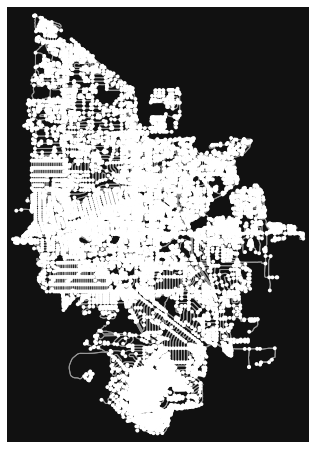

In [23]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

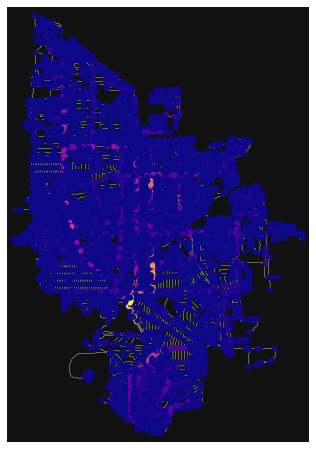

In [24]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.

# Eigenevector Centrality

In [27]:
Eigene_centrality = nx.eigenvector_centrality(D,weight="travel_time",tol=1.0e-3)
nx.set_node_attributes(G, values=Eigene_centrality, name="Eigene_centrality")

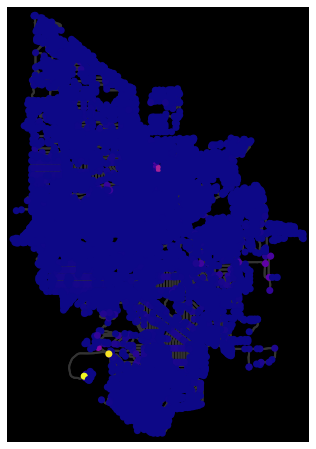

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:109: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [28]:
# plot the graph, coloring nodes by betweenness centrality
ec = ox.plot.get_node_colors_by_attr(G, "Eigene_centrality", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=ec, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, "Eigenvector_Centrality_Boulder_shapefile")

In [29]:
print('min_ec:', array([Eigene_centrality[k] for k in Eigene_centrality]).min())
print('mean_ec:',array([Eigene_centrality[k] for k in Eigene_centrality]).mean())
print('max_ec:',array([Eigene_centrality[k] for k in Eigene_centrality]).max())
print('std_ec:',array([Eigene_centrality[k] for k in Eigene_centrality]).std())

min_ec: 5.236276363079962e-10
mean_ec: 0.0006084048008253406
max_ec: 0.6480345597814487
std_ec: 0.008191839040422462


# Advanced NetworkX: Community detection with modularity 
#https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [30]:
communities = community.greedy_modularity_communities(G)

In [31]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')


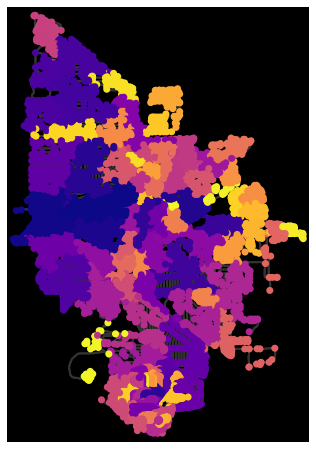

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\osmnx\io.py:109: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [32]:
# plot the graph, coloring nodes by betweenness centrality
mu = ox.plot.get_node_colors_by_attr(G, "modularity", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=mu, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, "Modularity_Boulder_shapefile")

In [33]:
#find the highest eigenvector centrality nodes in modularity class 0 (the first one):
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['Eigene_centrality'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])


Modularity Class 0 Sorted by Eigenvector Centrality:
Name: 176520109 | Eigenvector Centrality: 0.009588771911853755
Name: 176403075 | Eigenvector Centrality: 0.008265544197109904
Name: 176457182 | Eigenvector Centrality: 0.005195944146199429
Name: 176403087 | Eigenvector Centrality: 0.0033392461874653698
Name: 392971008 | Eigenvector Centrality: 0.002634600119019671


# Traffic level of Stress